In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
# Parameters using in this model:

T =1
N= 10
dt = T/N

X = 100000
sigma = 0.09
gamma = 1e-10
eta = 2.5e-10
alpha = 1e-5
P0 = 100



In [ ]:
def almgren_chriss_cost(x):

  cumulative_execution = np.cumsum(x)

  temp_impact = eta*np.sum(x**2)

  perm_impact = alpha*np.sum(cumulative_execution)

  risk = gamma*(sigma**2)*np.sum((T - np.arange(1, N+1) * dt)*(x**2))

  total_cost =  temp_impact + perm_impact + risk

  return total_cost


In [ ]:
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - X}

In [ ]:
bounds = [(0, X)] * N
x0 = np.full(N, X / N)

In [ ]:
result = minimize(almgren_chriss_cost, x0, method='SLSQP', bounds=bounds, constraints=constraints)


In [ ]:
optimal_trades = result.x
print("Optimal trade sizes:", optimal_trades)
print("Total cost:", almgren_chriss_cost(optimal_trades))


Optimal trade sizes: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
Total cost: 5.750364500000001


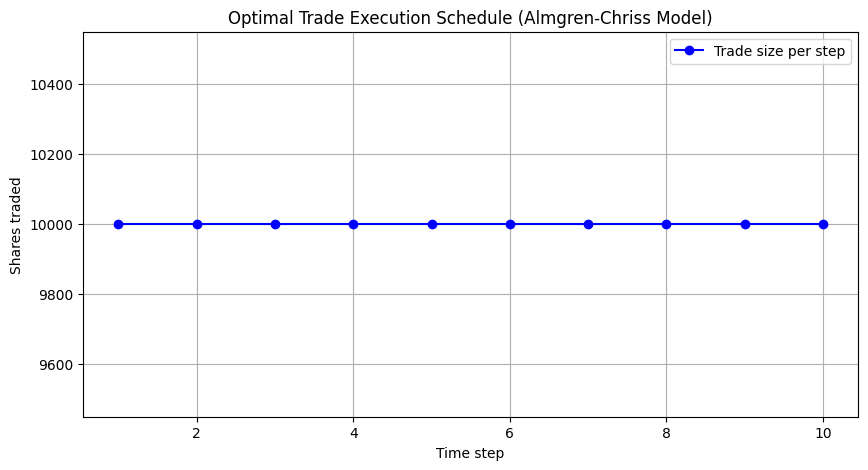

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, N + 1), optimal_trades, marker='o', linestyle='-', color='b', label='Trade size per step')
plt.xlabel('Time step')
plt.ylabel('Shares traded')
plt.title('Optimal Trade Execution Schedule (Almgren-Chriss Model)')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed


Optimal Parameters:
Gamma (Risk Aversion): 1e-06
Eta (Temporary Impact): 2.5e-06
Alpha (Permanent Impact): 1e-05
Minimum Cost: 31303.433730643068


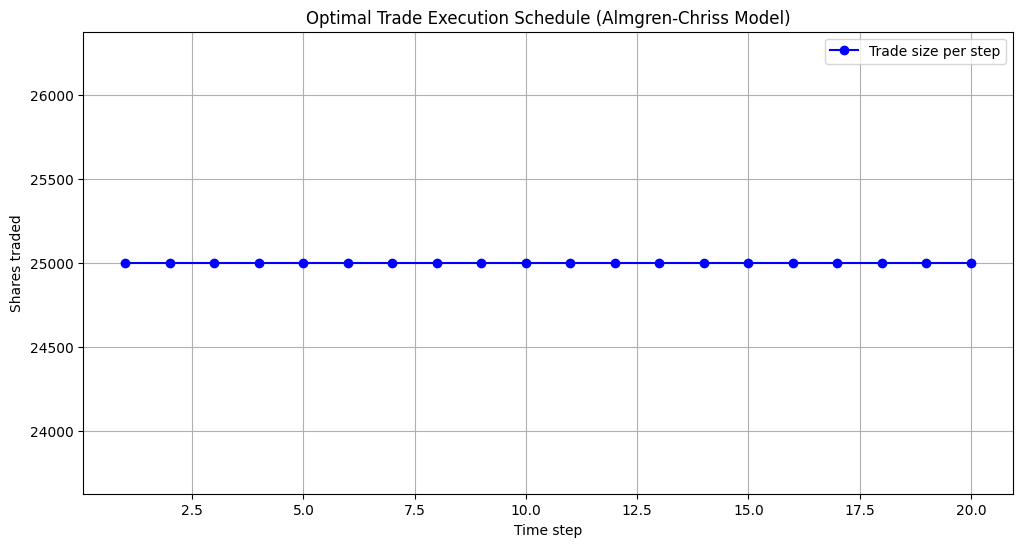

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf  # Yahoo Finance for stock data

# Step 1: Fetch Real Stock Data (AAPL as an example)
ticker = 'AAPL'
data = yf.download(ticker, start='2023-01-01', end='2023-12-31')['Close']

# Calculate daily returns and volatility
returns = data.pct_change().dropna()
sigma = np.std(returns)  # Historical volatility

# Define basic parameters
T = 1  # Total time horizon
N = 20  # Number of time steps
dt = T / N  # Time step size
X = 500000  # Total shares to trade

# Define the cost function
def almgren_chriss_cost(x, gamma, eta, alpha):
    cumulative_execution = np.cumsum(x)
    temp_impact = eta * np.sum(x**2)
    perm_impact = alpha * np.sum(cumulative_execution)
    risk = gamma * sigma**2 * np.sum((T - np.arange(1, N + 1) * dt) * x**2)
    total_cost = temp_impact + perm_impact + risk
    return total_cost

# Define parameter grid for cross-validation
gamma_values = [1e-6, 1e-5, 5e-5]
eta_values = [2.5e-6, 5e-6, 7.5e-6]
alpha_values = [1e-5, 2e-5, 5e-5]

# Store results
results = []

# Perform cross-validation
for gamma in gamma_values:
    for eta in eta_values:
        for alpha in alpha_values:
            # Constraints: Sum of all trades must equal the total order size
            constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - X}

            # Bounds: Each trade size must be non-negative
            bounds = [(0, X)] * N

            # Initial guess: Even distribution of trades
            x0 = np.full(N, X / N)

            # Optimization: Minimize the cost function
            result = minimize(
                almgren_chriss_cost,
                x0,
                args=(gamma, eta, alpha),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints
            )

            # Store results
            total_cost = almgren_chriss_cost(result.x, gamma, eta, alpha)
            results.append((gamma, eta, alpha, total_cost, result.x))

# Find the optimal parameter set with the minimum cost
best_result = min(results, key=lambda x: x[3])

# Extract the optimal parameters and corresponding trade sizes
optimal_gamma, optimal_eta, optimal_alpha, min_cost, optimal_trades = best_result

# Display the optimal parameters and their corresponding cost
print(f"Optimal Parameters:")
print(f"Gamma (Risk Aversion): {optimal_gamma}")
print(f"Eta (Temporary Impact): {optimal_eta}")
print(f"Alpha (Permanent Impact): {optimal_alpha}")
print(f"Minimum Cost: {min_cost}")

# Plot the optimal trade execution schedule
plt.figure(figsize=(12, 6))
plt.plot(range(1, N + 1), optimal_trades, marker='o', linestyle='-', color='b', label='Trade size per step')
plt.xlabel('Time step')
plt.ylabel('Shares traded')
plt.title(f'Optimal Trade Execution Schedule (Almgren-Chriss Model)')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


Daily Volatility: 0.0225
Annual Volatility: 0.3567


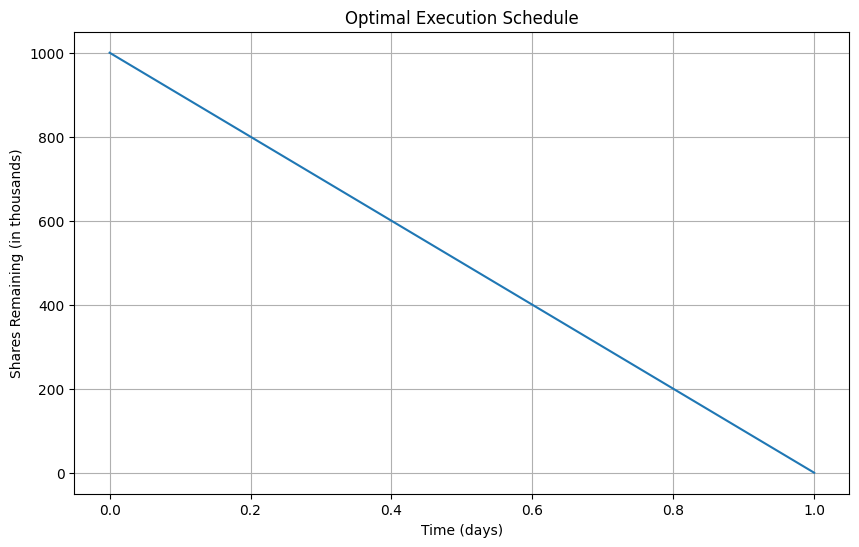

Expected Execution Cost: $1,052,500.01
Standard Deviation of Cost: $12,485.79


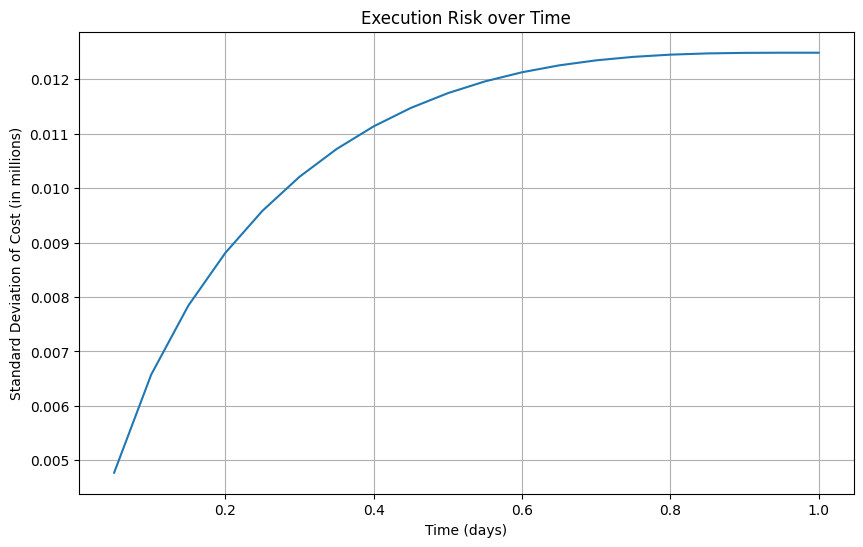

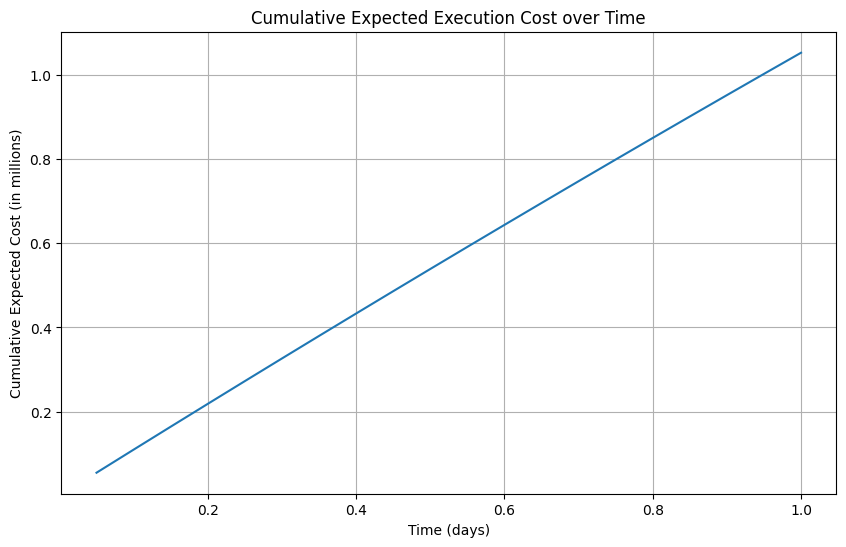

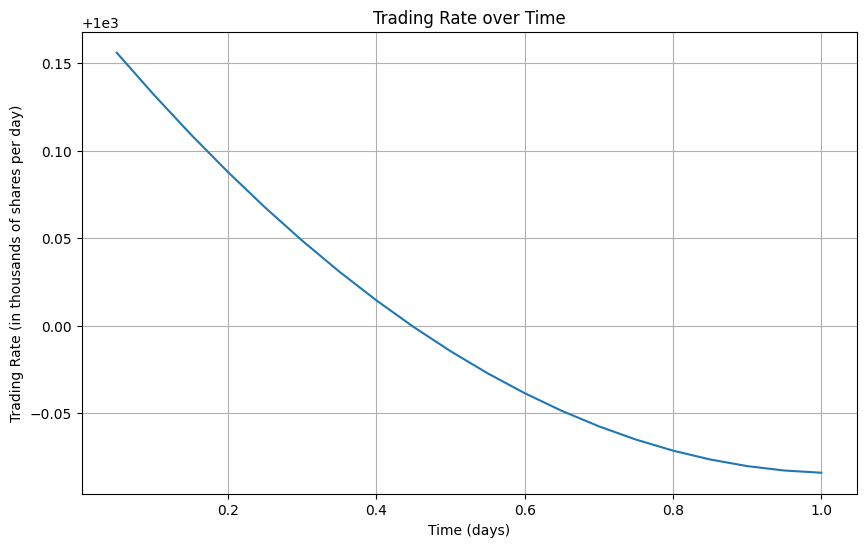

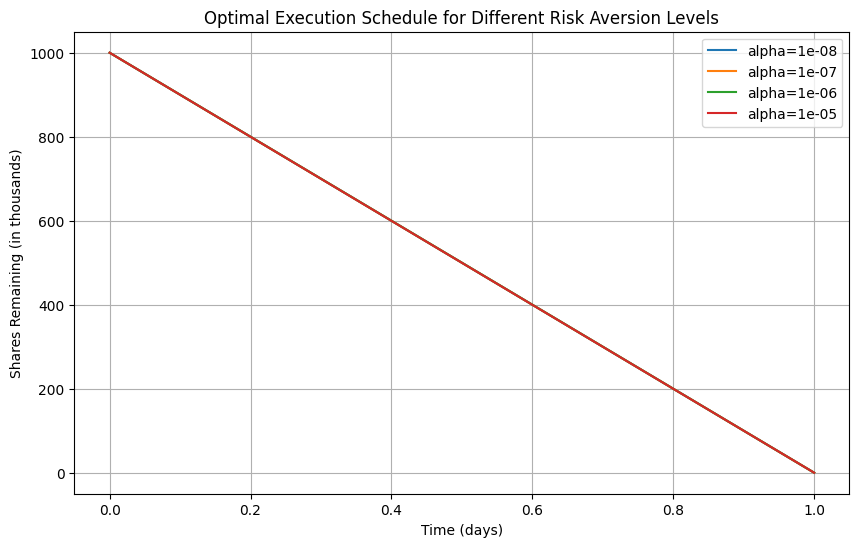

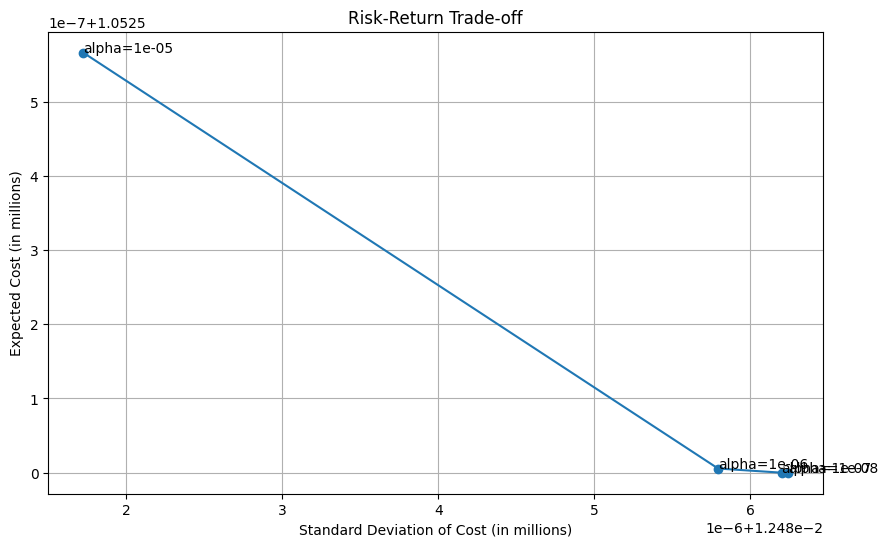

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Step 1: Fetch Historical Stock Data
# Choose a stock symbol, e.g., Apple Inc. (AAPL)
symbol = 'AAPL'
# Define the period for data
start_date = '2022-01-01'
end_date = '2022-12-31'

# Fetch historical data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)

# Step 2: Compute Daily Returns and Estimate Volatility
data['Returns'] = data['Adj Close'].pct_change()
daily_volatility = data['Returns'].std()
annual_volatility = daily_volatility * np.sqrt(252)
print(f"Daily Volatility: {daily_volatility:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")

# Step 3: Define Parameters for the Almgren-Chriss Model
# Total shares to sell
X = 1e6  # 1 million shares
# Time horizon in days
T = 1  # 1 day
# Number of discrete time periods (e.g., 20 intervals during the day)
N = 20
# Time interval
dt = T / N
# Risk aversion parameter (adjustable)
alpha = 1e-6
# Market parameters
sigma = daily_volatility  # volatility per day
# Average daily trading volume
ADV = data['Volume'].mean()
# Temporary and permanent impact parameters (illustrative values)
eta = 1e-6  # temporary impact parameter
gamma = 1e-7  # permanent impact parameter

# Step 4: Compute Optimal Execution Schedule
# Calculate kappa
kappa = np.sqrt(alpha * sigma**2 / eta)
# Time grid
t = np.linspace(0, T, N+1)  # N+1 points including t=0 and t=T
# Compute the optimal holdings
sinh_kappa_T = np.sinh(kappa * T)
x = X * np.sinh(kappa * (T - t)) / sinh_kappa_T
# Compute trade list (shares to sell in each interval)
trade_list = -np.diff(x)  # negative because we are selling
# Compute trading rate (shares per day)
v = -np.diff(x) / dt

# Step 5: Plot Optimal Execution Schedule
plt.figure(figsize=(10,6))
plt.plot(t, x / 1e3)
plt.xlabel('Time (days)')
plt.ylabel('Shares Remaining (in thousands)')
plt.title('Optimal Execution Schedule')
plt.grid(True)
plt.show()

# Step 6: Compute Expected Cost and Variance
# Permanent impact cost
permanent_impact_cost = gamma * np.sum(x[:-1] * v * dt)
# Temporary impact cost
temporary_impact_cost = eta * np.sum(v**2 * dt)
# Total expected cost
expected_cost = permanent_impact_cost + temporary_impact_cost
# Variance of cost
variance_cost = sigma**2 * np.sum(x[1:]**2 * dt)

print(f"Expected Execution Cost: ${expected_cost:,.2f}")
print(f"Standard Deviation of Cost: ${np.sqrt(variance_cost):,.2f}")

# Step 7: Plot Execution Risk over Time
# Cumulative variance up to each time point
cumulative_variance = sigma**2 * np.cumsum(x[1:]**2 * dt)
# Standard deviation over time
std_over_time = np.sqrt(cumulative_variance)
plt.figure(figsize=(10,6))
plt.plot(t[1:], std_over_time / 1e6)
plt.xlabel('Time (days)')
plt.ylabel('Standard Deviation of Cost (in millions)')
plt.title('Execution Risk over Time')
plt.grid(True)
plt.show()

# Step 8: Plot Cumulative Expected Execution Cost over Time
# Cumulative expected cost up to each time point
cumulative_permanent_cost = gamma * np.cumsum(x[:-1] * v * dt)
cumulative_temporary_cost = eta * np.cumsum(v**2 * dt)
cumulative_expected_cost = cumulative_permanent_cost + cumulative_temporary_cost
plt.figure(figsize=(10,6))
plt.plot(t[1:], cumulative_expected_cost / 1e6)
plt.xlabel('Time (days)')
plt.ylabel('Cumulative Expected Cost (in millions)')
plt.title('Cumulative Expected Execution Cost over Time')
plt.grid(True)
plt.show()

# Step 9: Plot Trading Rate over Time
plt.figure(figsize=(10,6))
plt.plot(t[1:], v / 1e3)
plt.xlabel('Time (days)')
plt.ylabel('Trading Rate (in thousands of shares per day)')
plt.title('Trading Rate over Time')
plt.grid(True)
plt.show()

# Step 10: Analyze Risk Aversion Levels
# Different risk aversion parameters
alphas = [1e-8, 1e-7, 1e-6, 1e-5]
plt.figure(figsize=(10,6))

for alpha in alphas:
    kappa = np.sqrt(alpha * sigma**2 / eta)
    sinh_kappa_T = np.sinh(kappa * T)
    x_alpha = X * np.sinh(kappa * (T - t)) / sinh_kappa_T
    plt.plot(t, x_alpha / 1e3, label=f'alpha={alpha}')

plt.xlabel('Time (days)')
plt.ylabel('Shares Remaining (in thousands)')
plt.title('Optimal Execution Schedule for Different Risk Aversion Levels')
plt.legend()
plt.grid(True)
plt.show()

# Step 11: Plot Risk-Return Trade-off
expected_costs = []
variance_costs = []

for alpha in alphas:
    kappa = np.sqrt(alpha * sigma**2 / eta)
    sinh_kappa_T = np.sinh(kappa * T)
    x_alpha = X * np.sinh(kappa * (T - t)) / sinh_kappa_T
    v_alpha = -np.diff(x_alpha) / dt
    permanent_impact_cost_alpha = gamma * np.sum(x_alpha[:-1] * v_alpha * dt)
    temporary_impact_cost_alpha = eta * np.sum(v_alpha**2 * dt)
    expected_cost_alpha = permanent_impact_cost_alpha + temporary_impact_cost_alpha
    variance_cost_alpha = sigma**2 * np.sum(x_alpha[1:]**2 * dt)
    expected_costs.append(expected_cost_alpha)
    variance_costs.append(variance_cost_alpha)

plt.figure(figsize=(10,6))
plt.plot(np.sqrt(variance_costs) / 1e6, np.array(expected_costs) / 1e6, marker='o')
for i, alpha in enumerate(alphas):
    plt.text(np.sqrt(variance_costs[i]) / 1e6, np.array(expected_costs[i]) / 1e6, f'alpha={alpha}')
plt.xlabel('Standard Deviation of Cost (in millions)')
plt.ylabel('Expected Cost (in millions)')
plt.title('Risk-Return Trade-off')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


symbol = 'AAPL'

start_date = '2022-01-01'
end_date = '2022-12-31'


data = yf.download(symbol, start=start_date, end=end_date)












[*********************100%***********************]  1 of 1 completed


In [ ]:
data['Returns'] = data['Adj Close'].pct_change()
daily_volatility = data['Returns'].std()
annual_volatility = daily_volatility * np.sqrt(252)
print(f"Daily Volatility: {daily_volatility:.4f}")
print(f"Annual Volatility: {annual_volatility:.4f}")

Daily Volatility: 0.0225
Annual Volatility: 0.3567


In [ ]:
# Get the initial price for cost calculations
initial_price = data['Adj Close'].iloc[0]

# Step 3: Define Parameters for the Almgren-Chriss Model
# Total shares to sell
X = 1e6  # 1 million shares
# Time horizon in days
T = 1  # 1 day
# Number of discrete time periods (e.g., 20 intervals during the day)
N = 20
# Time interval
dt = T / N
# Risk aversion parameter (adjustable)
alpha = 1e-6
# Market parameters
sigma = daily_volatility  # volatility per day
# Average daily trading volume
ADV = data['Volume'].mean()
# Temporary and permanent impact parameters (illustrative values)
eta = 1e-6  # temporary impact parameter
gamma = 1e-7  # permanent impact parameter


In [ ]:

# Step 4: Compute Optimal Execution Schedule
# Calculate kappa
kappa = np.sqrt(alpha * sigma**2 / eta)
# Time grid
t = np.linspace(0, T, N+1)  # N+1 points including t=0 and t=T
# Compute the optimal holdings
sinh_kappa_T = np.sinh(kappa * T)
x = X * np.sinh(kappa * (T - t)) / sinh_kappa_T
# Compute trade list (shares to sell in each interval)
trade_list = -np.diff(x)  # negative because we are selling
# Compute trading rate (shares per day)
v = trade_list / dt


In [ ]:

# Step 5: Compute Execution Cost and Risk Metrics
# Permanent impact cost per interval
c_perm = gamma * x[:-1] * v * dt
# Temporary impact cost per interval
c_temp = eta * v**2 * dt
# Total expected cost per interval
c_expected = c_perm + c_temp
# Variance of cost per interval
var_cost = sigma**2 * x[1:]**2 * dt
# Cumulative expected cost and variance
cumulative_expected_cost = np.cumsum(c_expected)
cumulative_variance = np.cumsum(var_cost)
# Standard deviation (execution risk) over time
std_over_time = np.sqrt(np.insert(cumulative_variance, 0, 0))
# Total initial value of shares to be sold
total_initial_value = X * initial_price
# Cumulative market impact cost percentage
market_impact_pct = cumulative_expected_cost / total_initial_value * 100
# Time points for intervals (excluding the initial point)
t_intervals = t[1:]

In [ ]:
# Step 6: Create DataFrame with Detailed Metrics
df = pd.DataFrame({
    'Time (days)': t_intervals,
    'Shares to Sell': trade_list,
    'Cumulative Execution Risk ($)': std_over_time[1:],  # Skip the first zero
    'Market Impact Cost (%)': market_impact_pct
})

# Convert execution risk from dollars to absolute value
df['Cumulative Execution Risk ($)'] = df['Cumulative Execution Risk ($)'].abs()

# Step 7: Display the DataFrame
print(df.to_string(index=False))


 Time (days)  Shares to Sell  Cumulative Execution Risk ($)  Market Impact Cost (%)
       0.025    25004.051372                    3464.186165                0.015344
       0.050    25003.743663                    4836.688388                0.030654
       0.075    25003.443846                    5847.623282                0.045928
       0.100    25003.151920                    6664.818619                0.061166
       0.125    25002.867884                    7354.228195                0.076370
       0.150    25002.591740                    7950.162447                0.091538
       0.175    25002.323486                    8473.300883                0.106671
       0.200    25002.063123                    8937.320364                0.121769
       0.225    25001.810651                    9351.870016                0.136832
       0.250    25001.566069                    9724.091076                0.151860
       0.275    25001.329378                   10059.468424                0

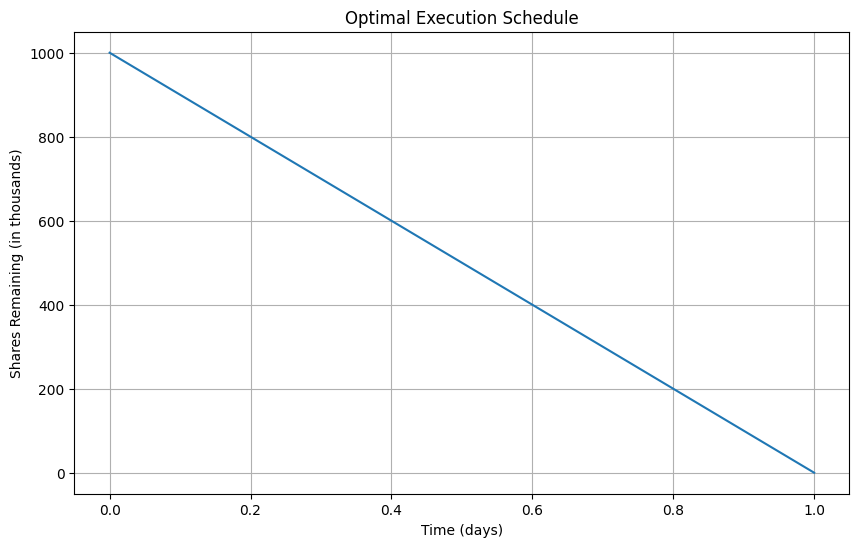

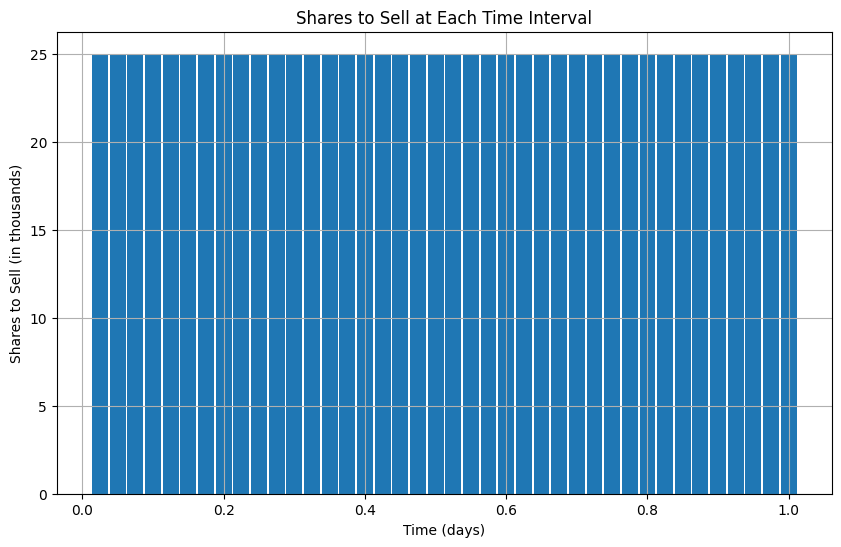

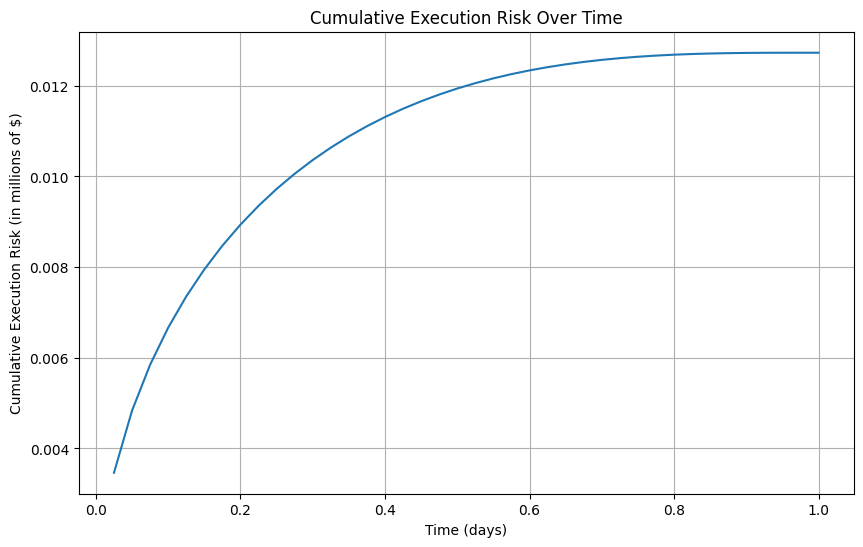

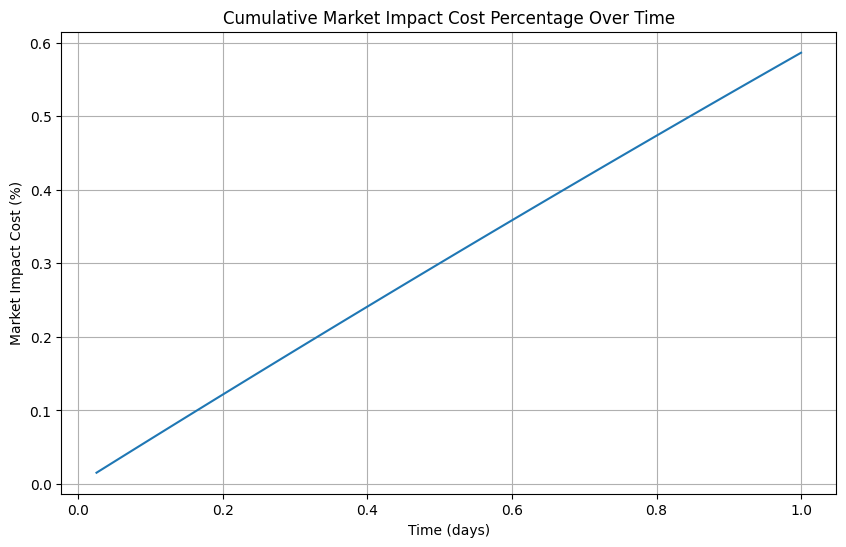

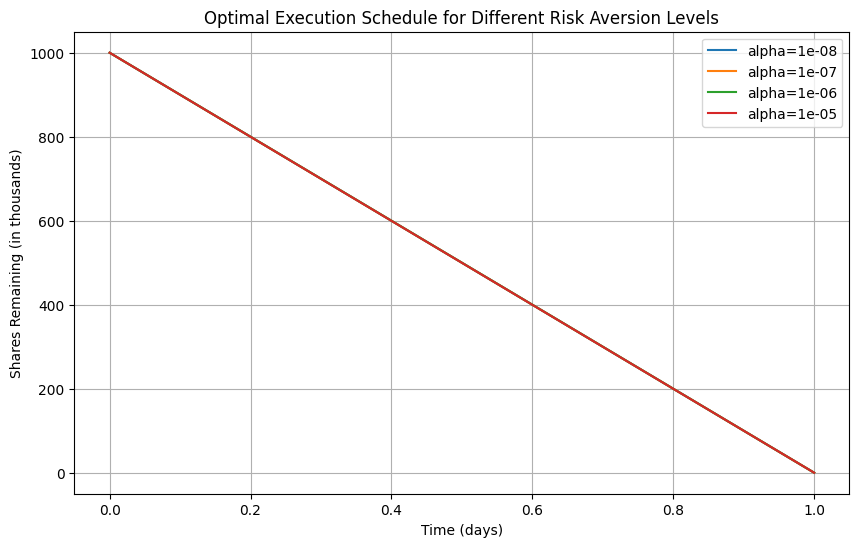

In [ ]:

# Step 8: Plot Optimal Execution Schedule
plt.figure(figsize=(10,6))
plt.plot(t, x / 1e3)
plt.xlabel('Time (days)')
plt.ylabel('Shares Remaining (in thousands)')
plt.title('Optimal Execution Schedule')
plt.grid(True)
plt.show()

# Step 9: Plot Shares to Sell at Each Time Interval
plt.figure(figsize=(10,6))
plt.bar(df['Time (days)'], df['Shares to Sell']/1e3, width=dt*0.9)
plt.xlabel('Time (days)')
plt.ylabel('Shares to Sell (in thousands)')
plt.title('Shares to Sell at Each Time Interval')
plt.grid(True)
plt.show()

# Step 10: Plot Cumulative Execution Risk Over Time
plt.figure(figsize=(10,6))
plt.plot(df['Time (days)'], df['Cumulative Execution Risk ($)']/1e6)
plt.xlabel('Time (days)')
plt.ylabel('Cumulative Execution Risk (in millions of $)')
plt.title('Cumulative Execution Risk Over Time')
plt.grid(True)
plt.show()

# Step 11: Plot Market Impact Cost Percentage Over Time
plt.figure(figsize=(10,6))
plt.plot(df['Time (days)'], df['Market Impact Cost (%)'])
plt.xlabel('Time (days)')
plt.ylabel('Market Impact Cost (%)')
plt.title('Cumulative Market Impact Cost Percentage Over Time')
plt.grid(True)
plt.show()

# Step 12: Analyze Risk Aversion Levels
# Different risk aversion parameters
alphas = [1e-8, 1e-7, 1e-6, 1e-5]
plt.figure(figsize=(10,6))

for alpha in alphas:
    kappa = np.sqrt(alpha * sigma**2 / eta)
    sinh_kappa_T = np.sinh(kappa * T)
    x_alpha = X * np.sinh(kappa * (T - t)) / sinh_kappa_T
    plt.plot(t, x_alpha / 1e3, label=f'alpha={alpha}')

plt.xlabel('Time (days)')
plt.ylabel('Shares Remaining (in thousands)')
plt.title('Optimal Execution Schedule for Different Risk Aversion Levels')
plt.legend()
plt.grid(True)
plt.show()

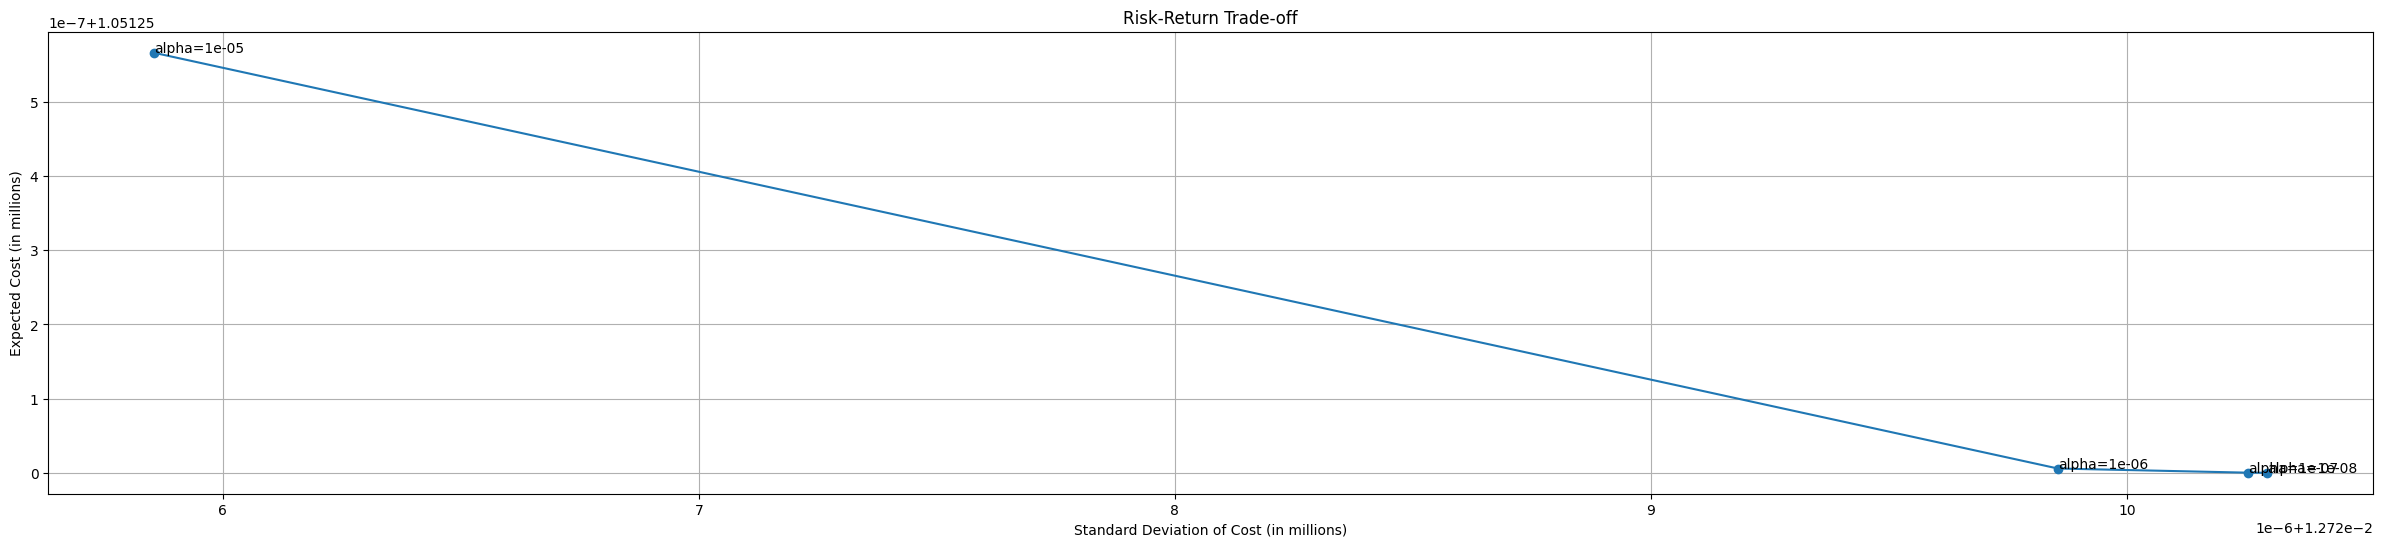

In [ ]:

# Step 13: Plot Risk-Return Trade-off
expected_costs = []
variance_costs = []

for alpha in alphas:
    kappa = np.sqrt(alpha * sigma**2 / eta)
    sinh_kappa_T = np.sinh(kappa * T)
    x_alpha = X * np.sinh(kappa * (T - t)) / sinh_kappa_T
    v_alpha = -np.diff(x_alpha) / dt
    # Expected cost components
    c_perm_alpha = gamma * x_alpha[:-1] * v_alpha * dt
    c_temp_alpha = eta * v_alpha**2 * dt
    expected_cost_alpha = np.sum(c_perm_alpha + c_temp_alpha)
    variance_cost_alpha = sigma**2 * np.sum(x_alpha[1:]**2 * dt)
    expected_costs.append(expected_cost_alpha)
    variance_costs.append(variance_cost_alpha)

plt.figure(figsize=(30,6))
plt.plot(np.sqrt(variance_costs) / 1e6, np.array(expected_costs) / 1e6, marker='o')
for i, alpha in enumerate(alphas):
    plt.text(np.sqrt(variance_costs[i]) / 1e6, np.array(expected_costs[i]) / 1e6, f'alpha={alpha}')
plt.xlabel('Standard Deviation of Cost (in millions)')
plt.ylabel('Expected Cost (in millions)')
plt.title('Risk-Return Trade-off')
plt.grid(True)
plt.show()